# Modest approach for Heston model


Original source of the notebook: Teichmann: https://nbviewer.jupyter.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/heston_calibration.ipynb

In [10]:
import QuantLib as ql
from math import pow, sqrt , log
import numpy as np
from scipy.optimize import least_squares, differential_evolution
from matplotlib import pyplot as plt,cm
from pandas import DataFrame
from itertools import product
import pandas as pd
import pickle
import os
import datetime as dt
from scipy.stats import norm

from src.rough_heston_simulation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
X = simulate_rough_heston(100, 1)

AssertionError: 

In [5]:
X

array([[1.        ],
       [0.9631365 ],
       [0.96195979],
       [0.96185198],
       [0.96291596],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [     

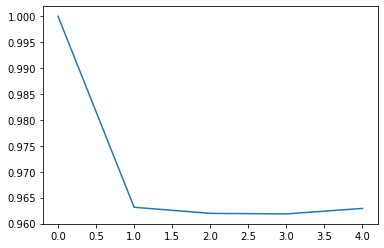

In [6]:
plt.plot(X[:, 0])

In [ ]:
# Calendar conventions
data_dir = os.getcwd()
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
# Option conventions
moneyness = [.8, .85, .9, .95, .975, .99, 1.0, 1.01, 1.025, 1.05, 1.1, 1.15, 1.2] # S_0/K 
delta_times = [15, 30, 45, 60, 90, 120, 180, 240, 300, 360, 420]

he_analytic = {'name' : 'Heston',
               'process' : ql.HestonProcess,
               'model' : ql.HestonModel, 
               'engine' : ql.AnalyticHestonEngine,
               'option_type' : ql.Option.Call,
               'transformation' : np.log, 
               'inverse_transformation' : np.exp}

In [10]:
def create_european_option(calculation_date, opt_type, strike_price, ttm):
# Create European options
    payoff = ql.PlainVanillaPayoff(opt_type, strike_price)
    maturity = calculation_date+int(ttm)
    exercise = ql.EuropeanExercise(maturity)
    return ql.VanillaOption(payoff, exercise)

def create_imp_vol_skeleton(strike_struct, expiration_dates_struct, 
                            calculation_date, spot_price):
    '''
    Create the structure (skeleton) on which it is possible to price all options.
    '''
    strikes = [spot_price/m for m in strike_struct]
    expiries = [calculation_date+d_time for d_time in expiration_dates_struct]
    ttm_days = [(d-calculation_date) for d in expiries] # time to maturity
    ttm_year = [day_count.yearFraction(calculation_date, d) for d in expiries]

    new_array = np.array((ttm_days,strikes))
    cartesian_product_vola_surface = list(product(*new_array))
    df = pd.DataFrame(cartesian_product_vola_surface, 
                        columns=['ttm','strikes'])
    return strikes, np.array((ttm_year)), expiries, df

def datetime_to_ql(d):
    return ql.Date(d.day,d.month,d.year)

def ql_to_datetime(dateql):
    return dt.datetime(dateql.year(), dateql.month(), dateql.dayOfMonth())
            
def save_dictionary(dictionary, name_dict, path=data_dir):
        filehandler = open(path+ '/' +name_dict+'.pkl','wb')
        pickle.dump(dictionary,filehandler)
        filehandler.close()

def load_dictionary(name_dict, path=data_dir):
        with open(path+ '/' +name_dict+'.pkl', 'rb') as handle:
            dictionary = pickle.load(handle)
        return dictionary

def plt_surf(Z, z_label='ivs', main_title='Heston Imp Vola Surface', string1='', string2='',string3='',W=None):
    
    X, Y = np.meshgrid( moneyness, delta_times )
    Z = Z.reshape(len(X),len(X[0]))
    fig = plt.figure()
    if W is None:
        ax = fig.add_subplot(1, 1, 1, projection='3d', xlabel='time to maturity in days', ylabel='moneyness', zlabel=z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        surf=ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf, shrink=0.6, aspect=20,ax=ax)
    else:
        W = W.reshape(len(X),len(X[0]))
        fig.set_figheight(8); fig.set_figwidth(16)
        ax1 = fig.add_subplot(1, 2, 1, projection='3d', xlabel='time to maturity in days', ylabel='moneyness', zlabel=z_label)
        ax1.text2D(0.06, 0.98, string1, transform=ax1.transAxes)
        ax1.text2D(0.06, 0.94, string3, transform=ax1.transAxes)
        surf1=ax1.plot_surface(Y, X, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20)
        
        ax2 = fig.add_subplot(1, 2, 2, projection='3d', xlabel='time to maturity in days', ylabel='moneyness', zlabel=z_label)
        ax2.text2D(0.06, 0.98, string1, transform=ax2.transAxes)
        ax2.text2D(0.06, 0.94, string2, transform=ax2.transAxes)
        surf2=ax2.plot_surface(Y, X, W, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf2, shrink=0.6, aspect=20)
                       
    fig.suptitle(main_title)
    

NameError: name 'data_dir' is not defined

In [11]:
'''
 - Search for the implied volatility - 
Since the differential evolution algorithm is extremly long, I have to use
another method to derive the implied volatility for option prices.
References are Li and Lee (2011) and Stefanica and Radoicic (2017).
'''

def approx_func(x):
    return 0.5 + 0.5*np.sign(x)*np.sqrt(1. - np.exp(-2.*(x**2)/np.pi))

def guess_StefanicaRadoicic(option_type, strike, option_price, spot_price,
                            ir_discount, dr_discount):
    
    forward = spot_price * dr_discount / ir_discount
    ey = forward/strike #ey=exp(y)
    emy = strike/forward #emy=exp(-y)
    y = np.log(ey)
    alpha = option_price/(strike*ir_discount)
    
    if option_type==1:
        #Call
        R = 2.*alpha - ey + 1.
    else:
        #Put
        R = 2.*alpha + ey - 1.
    pi_term = 2./np.pi
    arg_exp_term = (1.-pi_term)*y
    R2 = R**2
    
    a = np.exp(arg_exp_term)
    A = (a - 1./a)**2
    b = np.exp(pi_term*y)
    B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
    C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
    beta = 2.*C / (B + np.sqrt(B**2 + 4.*A*C))
    gamma = - np.pi/2.*np.log(beta)
    
    if y>=0.:
        if option_type==1: #call
            O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
        else:
            O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
        if option_price <= O0:
            nu = np.sqrt(gamma+y) - np.sqrt(gamma-y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    else:
        if option_type==1: #call
            O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
        else:
            O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
        if option_price <= O0:
            nu = np.sqrt(gamma-y) - np.sqrt(gamma+y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    return nu

def Phi(x,nu):
    nu2 = nu**2
    abs_term = 2.*np.abs(x)
    return (nu2-abs_term)/(nu2+abs_term)
def N_plus(x,nu):
    return norm.cdf(x/nu + 0.5*nu)
def N_minus(x,nu):
    return np.exp(-x)*norm.cdf(x/nu - 0.5*nu)
def F(nu, x, c_star, omega):
    return c_star + N_minus(x,nu) + omega*N_plus(x,nu)
def G(nu, x, c_star, omega):
    argument = F(nu, x, c_star, omega)/(1.+omega)
    term = norm.ppf(argument)
    return term + np.sqrt(term**2 + 2.*np.abs(x))
    
def SOR_TS(option_type, strike, discount_ir, discount_dr, option_price, 
                     spot_price, guess, omega, accuracy, max_iterations=20):
    
    assert (option_price >= 0.),'Price must be positive.'
    
    forward = spot_price * discount_dr / discount_ir
    x = np.log(forward/strike)
    
    if option_type==1:  #call
        c = option_price/(spot_price*discount_dr)
    else:   #put
        c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
    if x > 0.:
        # formula in-out duality
        c = c*forward/strike + 1. - forward/strike
        assert (c >= 0.),'Normalized price must be positive.'
        x = -x
    
    if not guess:
        guess = guess_StefanicaRadoicic(option_type, strike, option_price, 
                                       spot_price, discount_ir, discount_dr)
    assert (guess >= 0.),'Initial guess must be positive.'
    
    nIter = 0
    nu_k = nu_kp1 = guess
    difference = 1.
    while (np.abs(difference)>accuracy and nIter<max_iterations):
        nu_k = nu_kp1
        alpha_k = (1.+omega)/(1.+Phi(x,nu_k))
        nu_kp1 = alpha_k*G(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
        difference = nu_kp1 - nu_k
        nIter +=1
    return nu_kp1

In [12]:
The simple Heston model is:

SyntaxError: invalid syntax (<ipython-input-12-cbcafcdded71>, line 1)

In [ ]:
class Heston:
    def __init__(self, model_dict=he_analytic, create_new=True, spot_price=100., risk_free_rate=0.01, 
                 dividend_rate=0.0, inst_var=0.1,calculation_date=ql.Date(8,11,2015), 
                 expiration_dates_struct=delta_times, strike_struct=moneyness,
                 mean_rev_speed=None, eq_var=None, vol_of_vol=None, correlation=None):
        '''
        This class implements the Heston model for a series of given parameters.
        The output will be a dataframe where the columns are parameters, strikes
        time_to_maturities, prices and values of the volatility surface.
        '''       
        
        if create_new==True:
            self.create_model( date=calculation_date )
         
        else:
            self._model_dict = model_dict      
            self.option_type = self._model_dict['option_type']
            self.calculation_date = calculation_date
            ql.Settings.instance().evaluationDate = self.calculation_date

            # Tolerance on implied volatility error
            self.tol = 1.e-14

            #heston model parameters
            self.sigma = vol_of_vol
            self.rho = correlation
            self.theta = eq_var
            self.kappa = mean_rev_speed
            self.params={'kappa':self.kappa,'theta':self.theta, 'sigma': self.sigma,'rho': self.rho}


            # volatility surface structure
            self.strikes, self.ttm, self.expiries, self.df = create_imp_vol_skeleton(strike_struct,
                                        expiration_dates_struct, calculation_date, spot_price)

            # Yield curve, dividends, spot and instantaneous volatility
            self.risk_free_rate = risk_free_rate
            self.dividend_rate = dividend_rate
            self.spot_price = spot_price
            self.v0 = inst_var
            self.obs={'S0':self.spot_price, 'ir':self.risk_free_rate, 'dr':self.dividend_rate, 'v0':self.v0}

            self.ircurve = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date,self.risk_free_rate,day_count))
            self.dividend = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate,day_count))
            self.spot = ql.QuoteHandle(ql.SimpleQuote(self.spot_price))

            self.process = self._model_dict['process'](self.ircurve,self.dividend,self.spot, self.v0,self.kappa,self.theta,self.sigma,self.rho)
            self.model = self._model_dict['model'](self.process)
            self.engine = self._model_dict['engine'](self.model)

            eu_options = [ create_european_option(self.calculation_date,self.option_type,s,t) 
                                           for s,t in zip(self.df['strikes'], self.df['ttm']) ] 
            [opt.setPricingEngine(self.engine) for opt in eu_options]
            self.df['price'] = [o.NPV() for o in eu_options]

            self.ivs=self.get_implied_vola()
                

    # Methods for the generation of the fake volatility surfaces
    def __generate_ir(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.08)
    def __generate_dr(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.03)
    def __generate_sp(self):
        return 100*(np.random.beta(a=8, b=8) + 1.0E-2)
    def __generate_theta(self):
        return np.random.uniform(low=0.05, high=0.8)
    def __generate_v0(self):
        return np.random.uniform(low=0.001, high=0.9)**2
    def __generate_rho(self):
        return np.random.uniform(low= -0.99, high= 0.99)
    def __generate_kappa(self):
        return np.random.uniform(low=0.5, high=10.)
    def __generate_sigma(self):
        return np.random.uniform(low=0.05, high=0.8)


    def create_model(self, date, create_new=False, **kwargs):
        '''
        Use fake (random) datas to create the data structure for the Heston model
        and the volatility surface.
        '''
        ir = kwargs.get('ir', self.__generate_ir())
        dr = kwargs.get('dr', self.__generate_dr())
        sp = kwargs.get('sp', self.__generate_sp())
        v0 = kwargs.get('v0', self.__generate_v0())
        rho = kwargs.get('rho', self.__generate_rho())
        sigma = kwargs.get('sigma', self.__generate_sigma()) #vol of vol! Not implied vola!
        # Loop until the Feller condition is satisfied
        theta = kwargs.get('theta', self.__generate_theta())
        kappa = kwargs.get('kappa', self.__generate_kappa())
        while 2*kappa*theta <= sigma**2:
            theta = self.__generate_theta()
            kappa = self.__generate_kappa()

        self.__init__(model_dict=he_analytic, create_new=create_new, spot_price=sp, risk_free_rate=ir,
                            dividend_rate=dr, calculation_date=date, 
                            expiration_dates_struct=delta_times, 
                            strike_struct=moneyness, mean_rev_speed=kappa,
                            eq_var=theta, vol_of_vol=sigma, correlation=rho,
                            inst_var=v0)

    def show_ivs(self):
        '''
        Plot implied volatility surface
        '''
        obs_str = ['S0 =', 'ir =', 'dr =', 'v0 =']
        obs = [self.spot_price, self.risk_free_rate, self.dividend_rate, self.v0]
        obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]
        params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
        params = [self.kappa, self.theta, self.sigma, self.rho]
        params_str = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, params)]
        plt_surf( Z=np.array(self.ivs), z_label='ivs', 
                     main_title='Heston Imp Vola Surface',
                     string1=', '.join(o for o in obs_str), 
                     string2=', '.join(p for p in params_str) )
        
    def get_implied_vola(self):
        ivs = []
        for i in range(len(self.df['price'])):
            # Find the implied volatility through other algorithms
            #https://en.wikipedia.org/wiki/Discounting#Discount_factor
            sol = 0.0
            discount_ir = self.ircurve.discount(self.calculation_date+int(self.df['ttm'][i]))
            discount_dr = self.dividend.discount(self.calculation_date+int(self.df['ttm'][i]))
            try:
                sol = SOR_TS(self.option_type, self.df['strikes'][i], discount_ir, discount_dr, 
                             self.df['price'][i], self.spot.value(), guess=None, 
                             omega=1., accuracy=self.tol)
            except Exception as error:
                print('Caught this error: ' + repr(error))
            yearly_ttm = day_count.yearFraction(self.calculation_date, self.calculation_date+int(self.df['ttm'][i]))
            sol = sol/np.sqrt(yearly_ttm)
            ivs.append(sol)
            if ivs[i]==0.:
                raise ValueError('Zero implied volatility!')
        return ivs
    
    def create_historical_data(self,first_date,end_date,save=True,**kwargs):
        '''
        for every date between first_date and end_date create heston with random params and corresponding impvols
        '''
        #### Dates
        self.dates = pd.date_range(ql_to_datetime(first_date), ql_to_datetime(end_date))
        self.dates_ql = [datetime_to_ql(d) for d in self.dates]
        
        # Set seed
        seed = kwargs.get('seed',0)
        print('Seed: %s'%seed)
        np.random.seed(seed)
        
        # Dictionaries
        observables = {} #contains s0, ir, dr and v0
        hist_parameters = {} #contains heston params
        hist_df = {} #contains the entire data_frame with ttm, strikes, prices
        hist_iv = {} #contains the implied vola surface given by the data_frame
        k = 0
        while k<len(self.dates_ql):
            self.calculation_date = self.dates_ql[k]
            self.create_model(self.calculation_date) ; date= ql_to_datetime(self.calculation_date);
            try:
                hist_iv[date] = self.ivs
            except (ValueError) as e:
                print(e)
            else:
                observables[date] = np.array( (self.spot_price, self.risk_free_rate, self.dividend_rate, self.v0) )
                hist_parameters[date] = np.array( (self.kappa, self.theta, self.sigma, self.rho) )                                           
                hist_df[date] = self.df #ttm, strikes,ttm,prices
                print('Date: ', date); print('Params: ', hist_parameters[date] )
                k += 1
        if  save == True:
            print('Saving historical data')  
            save_dictionary(dictionary=observables, name_dict='observables' )
            save_dictionary(dictionary=hist_parameters, name_dict='hist_parameters' )
            save_dictionary(dictionary=hist_df, name_dict='hist_df' )
            save_dictionary(dictionary=hist_iv, name_dict='hist_iv')
            
            
    def create_training_data(self, nb_samples, save=True, **kwargs):
        '''
        for a certain date create heston model with random params and calculate impvols
        '''
        # Set seed
        seed = kwargs.get('seed',0)
        np.random.seed(seed)
        print('NN-training data are produced')
        
        x = []
        y = []
        ql.Settings.instance().evaluationDate = self.calculation_date
        i = 0; err_no=0
        while i<nb_samples:
            try:
                self.create_model(date= ql.Settings.instance().evaluationDate)
            except (ValueError) as e:
                err_no+=1
                print(e,'@sample %s' %(i+1))
                print('Tot. no. of Errors: %s' %err_no)
            else:
                x.append([self.spot_price, self.risk_free_rate, self.dividend_rate,self.v0,
                                                                self.kappa,self.theta,self.sigma,self.rho])
                y.append(self.ivs)
                i += 1
        if  save == True:
            print('Saving data for training of NN as heston_train_inputNN and heston_train_outputNN')
            np.save(data_dir+'/'+'heston_train_inputNN', x)
            np.save(data_dir+'/'+'heston_train_outputNN', y)
        return (x,y)

In [ ]:
# %%time
h=Heston()
# h.create_training_data(100000,seed=1); #takes ca. 1h for n=20000. t ~ O(n)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input, ELU, add
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import VarianceScaling, RandomUniform
from tensorflow.keras.utils import plot_model
from copy import deepcopy, copy

In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split

params=np.load('heston_train_inputNN.npy')
iv=np.load('heston_train_outputNN.npy')

params_train, params_valid, iv_train, iv_valid=sk.model_selection.train_test_split(params,iv, train_size=0.8, random_state=1)
params_valid, params_test, iv_valid, iv_test=sk.model_selection.train_test_split(params_valid,iv_valid, train_size=0.5, random_state=1)

In [ ]:
# def generate_nn(nb_unit=int(2**8), layers=10, activation=ELU(1.0), optimizer=Nadam(learning_rate=5e-4,clipnorm=1.)):
#     init= tf.keras.initializers.GlorotUniform(seed=1)
#     ## Input of model
#     input = Input(shape=(8,))
#     # First layer
#     x = Dense(nb_unit, kernel_initializer=init,kernel_constraint=MaxNorm(5, axis=0),use_bias=False)(input)
#     x = BatchNormalization()(x)
#     x = activation(x)
#     x = Dropout(0)(x)

#     # Middle layers
#     for i in range(layers-1):
#         x = Dense(nb_unit, kernel_initializer=init, kernel_constraint=MaxNorm(5, axis=0), use_bias=False)(x)
#         x = BatchNormalization()(x)
#         x = activation(x)
#         x = Dropout(0)(x)
#         x = activation(x)

#     # Last layer
#     x = Dense(143, kernel_initializer=init, kernel_constraint=MaxNorm(5, axis=0), use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = Activation('linear')(x)
#     x = Dropout(0)(x)

#     ## Put together input and output
#     nn = Model(inputs=input, outputs=x)

#     # Compile
#     nn.compile(optimizer, loss='mse')
    
#     return nn

In [ ]:
# reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=60, min_lr=9e-10, verbose=1)
# earlyStopping = EarlyStopping(monitor='val_loss', patience=200)
# nn=generate_nn(layers=12)
# nn.fit( params_train, iv_train, batch_size=1024, epochs=350, verbose=2, callbacks=[reduceLR,earlyStopping],
#                           validation_data=(params_valid, iv_valid) )

In [ ]:
# nn.save('model') 

In [ ]:
nn = tf.keras.models.load_model('model')

In [ ]:
h.create_historical_data(first_date=ql.Date(1,1,2017),end_date=ql.Date(5,1,2017),seed=1)

In [ ]:
def f_cal(heston, neural_map, l2=False):
    def cost_function(params):
        params = params.flatten().tolist()
        input_params = [heston.spot_price, heston.risk_free_rate, heston.dividend_rate, heston.v0]
        input_params.extend(params)
        prediction = neural_map.predict( np.array( [input_params] ) )
        diff = prediction - heston.ivs #absolute error
        if l2:
            return np.sum(diff**2)
        else:
            return np.sum(np.abs(diff))
    return cost_function

In [ ]:
def illustration_plot(neuralnet, heston):
    obs = load_dictionary('observables'); params = load_dictionary('hist_parameters');ivs = load_dictionary('hist_iv')
    for date in heston.dates:
        test=np.concatenate( [obs[date], params[date] ])
        test=np.array([test])
        Z_test=neuralnet.predict(test)  
        str1='S0= {:.5}, ir= {:.5}, dr= {:.5}, v0= {:.5}'.format(*obs[date])
        str2=r"$\kappa =$ {:.5} , $\theta =$ {:.5}, $\sigma =$ {:.5}, $\rho =$ {:.5}".format(*params[date])
        plt_surf(Z=Z_test,W=np.array(ivs[date]),string1=str1,string2=str2,string3=str2)

In [ ]:
he_calibration_bounds = [(0.001,15.), (0.001,6.), (0.005,4.), (-0.999,0.999)]
def calibration_plot(neuralnet, heston):
    obs = load_dictionary('observables'); params = load_dictionary('hist_parameters');ivs = load_dictionary('hist_iv')
    for date in heston.dates:
        heston.create_model(datetime_to_ql(date),sp=obs[date][0],ir=obs[date][1],dr=obs[date][2],v0=obs[date][3],
                             kappa=params[date][0], theta=params[date][1],sigma=params[date][2], rho=params[date][3])
        sol = differential_evolution(f_cal(heston,neuralnet,True), bounds=he_calibration_bounds, maxiter=100)
        test=np.concatenate( [obs[date], sol.x ] )
        test=np.array([test])
        Z_test=neuralnet.predict(test)  
        str1='S0= {:.5}, ir= {:.5}, dr= {:.5}, v0= {:.5}'.format(*obs[date])
        str2=r"$\kappa =$ {:.5} , $\theta =$ {:.5}, $\sigma =$ {:.5}, $\rho =$ {:.5}".format(*params[date]) 
        str3=r"$\kappa =$ {:.5} , $\theta =$ {:.5}, $\sigma =$ {:.5}, $\rho =$ {:.5}".format(*sol.x)
        plt_surf(Z=Z_test,W=np.array(ivs[date]),string1=str1,string2=str2,string3=str3)

In [ ]:
illustration_plot(nn,h)

In [ ]:
%%time
calibration_plot(nn,h)